# Dinamic stochastic models in Python

## Forecasting non-observables

1. Load libraries

In [1]:
import os
root_path = os.getcwd().split('Ignorar_Backup',)[0]

In [2]:
import sys
sys.path.append(root_path + '02_Libraries')
import DSGE_LinearMethods as DLM
import DSGE_PreProcessing as DPP
import HandleTimeSeries as HTS
import sympy as sp
sp.init_session(use_latex=True)

IPython console for SymPy 1.12 (Python 3.12.4-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



* Check Libraries below are actually needed

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

In [4]:
def adjust_column_widths(table, ax):
    for i, col in enumerate(table.get_celld().values()):
        max_width = max([len(str(cell.get_text().get_text())) for cell in table.get_celld().values() if cell.get_text().get_text() != ''])
        table.auto_set_column_width([i])
        for key, cell in table.get_celld().items():
            if key[1] == i:
                cell.set_width(max_width * 0.1)

1. Procesing and solving the model

In [5]:
Mod = DPP.process_file3(root_path + '04_Modelo/MPTBolsillo.txt')
Mod = DLM.SolveModel(Mod, root_path + "04_Modelo/Cal_MPTBolsillo.txt", True)

-> Stability conditions met

Steady state
            User supplied  Numerical
DY_eq                5.30       5.30
DYs_eq               2.10       2.10
Ds                   0.00       0.00
y                    0.00       0.00
ys                   0.00       0.00
Dpae                 2.00       2.00
Dp                   2.00       2.00
Dp(-2)               2.00       2.00
Dp(-1)               2.00       2.00
D4p                  2.00       2.00
Dpsae                2.00       2.00
Dpsae(-2)            2.00       2.00
Dpsae(-1)            2.00       2.00
ED4p                 2.00       2.00
Dpm                  2.00       2.00
Dpm(-2)              2.00       2.00
Dpm(-1)              2.00       2.00
Meta                 2.00       2.00
i                    3.75       3.75
ieq                  3.75       3.75
zmn                  1.75       1.75
zme                  0.00       0.00
Ds(-2)               0.00       0.00
Ds(-1)               0.00       0.00
ED4s                 0.00       0

3. Load data

In [6]:
Describ, DBobs = HTS.ReadDB_excel(root_path + 'Tarea/DataTarea.xlsx', sheet='VarObs')

In [7]:
var = DLM.sympy_to_list(Mod['Desc.']['Declared Endogenous'])
varexo = DLM.sympy_to_list(Mod['Desc.']['Shocks'])

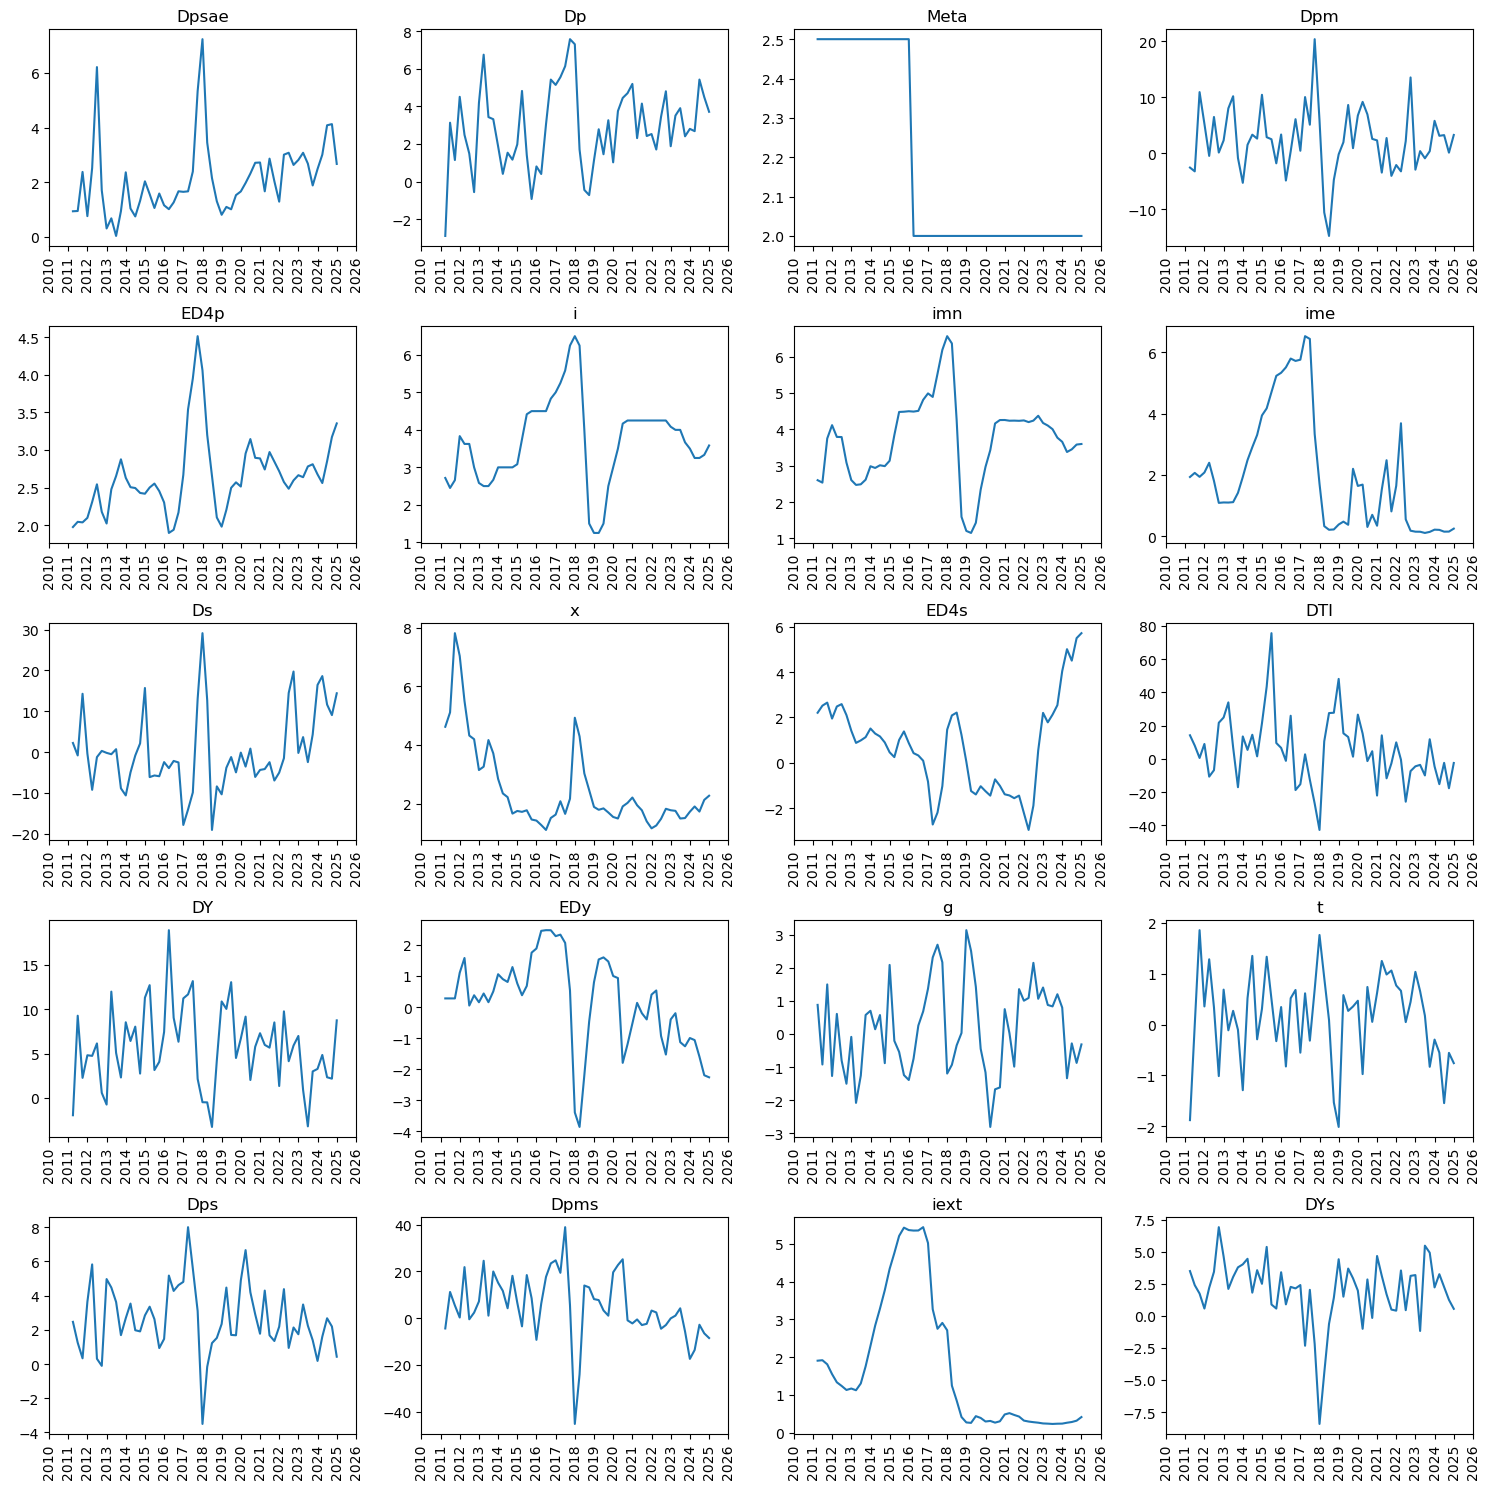

In [8]:
obsnames = DLM.sympy_to_list(Mod['StateSpaceForm']['obs_names'])
num_cols = len(obsnames)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))


for idx, col in enumerate(obsnames):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(DBobs.index, DBobs[col], linestyle='-')
    axs[row, col_idx].set_title(col)
    axs[row, col_idx].tick_params(axis='x', rotation = 90)
    axs[row, col_idx].set_xticks(axs[row, col_idx].get_xticks()[::4])

    axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

In [9]:
DF_s, DF_u, minuslogL = DLM.KFts(DBobs, Mod, {'diffuse':False})

In [10]:
SS = Mod['Solution']['Y0'].reshape(-1,1)

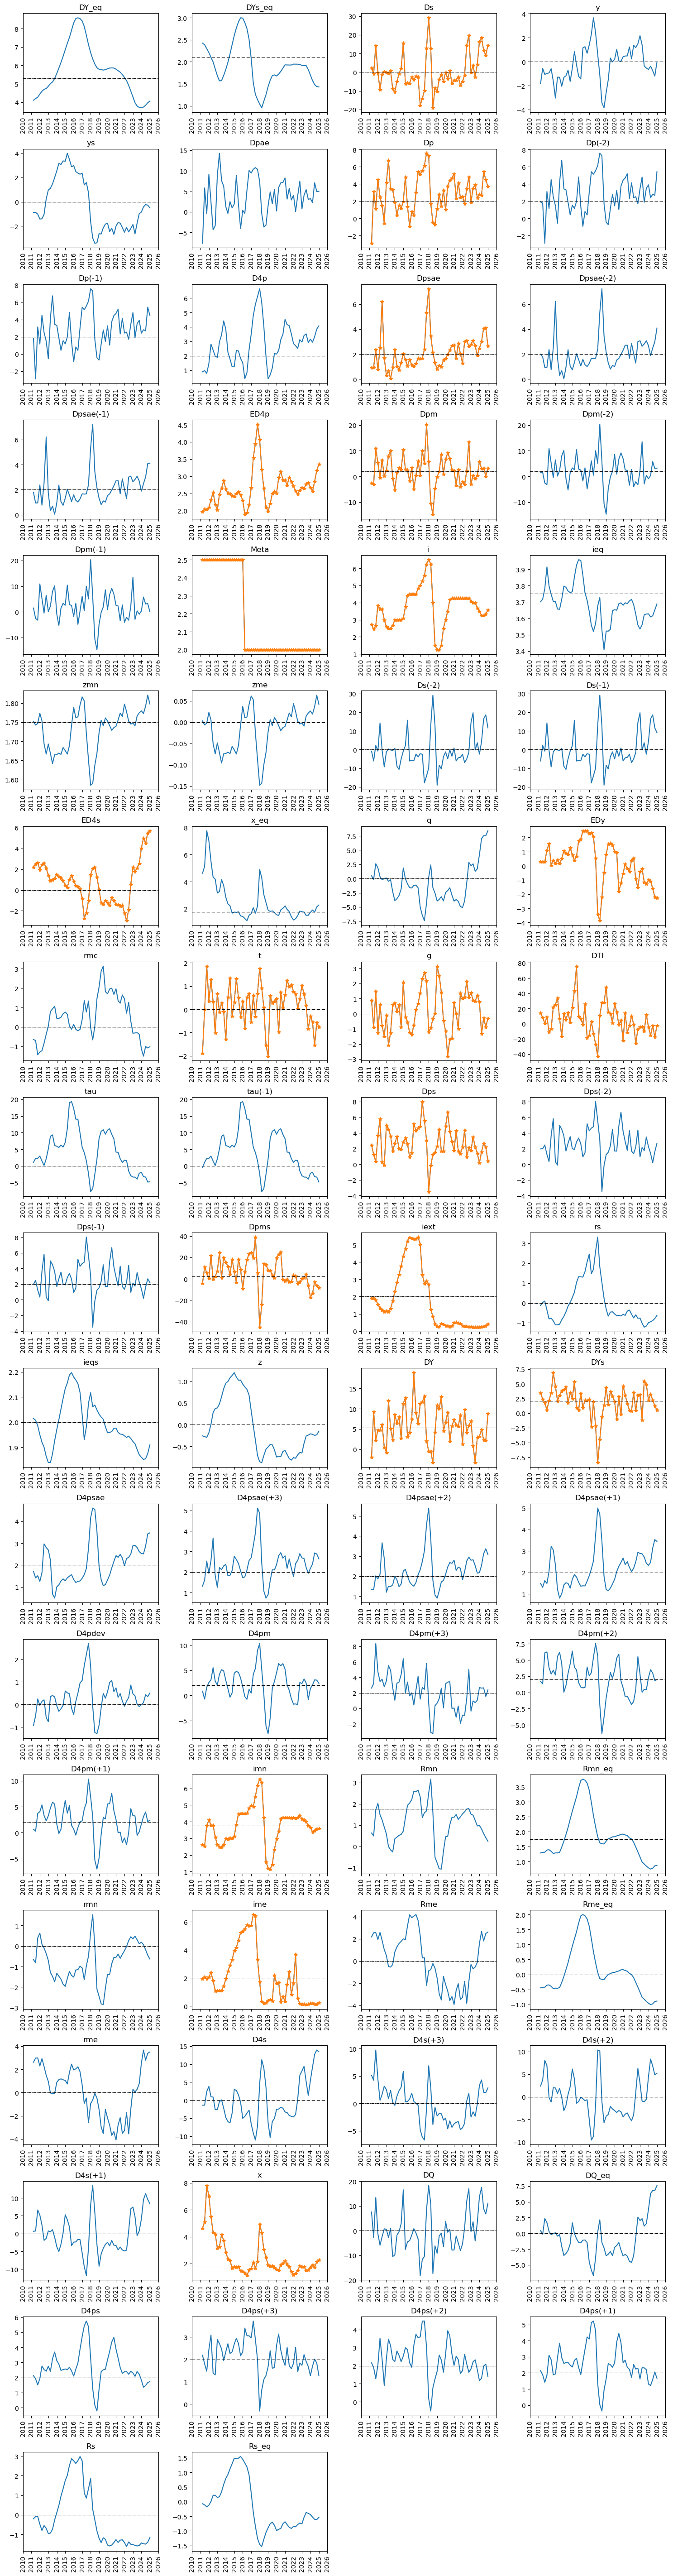

In [11]:
columns = DF_s.columns
num_cols = len(columns)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))


for idx, col in enumerate(columns):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(DF_s.index, DF_s[col], linestyle='-')
    axs[row, col_idx].set_title(col)
    observable = False
    for obs in obsnames:
        if col == obs:
            observable = True
    if observable:
        axs[row, col_idx].plot(DF_s.index, DBobs[col], linestyle='-',marker='*')
    axs[row, col_idx].tick_params(axis='x', rotation = 90)
    axs[row, col_idx].set_xticks(axs[row, col_idx].get_xticks()[::4])

    axs[row, col_idx].axhline(y=SS[idx], color='black', linestyle='-.', linewidth=0.75)

    axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

In [12]:
Data = DF_s

# Forecast

1. Unconditional

In [13]:
FH = 8
FDB = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1')

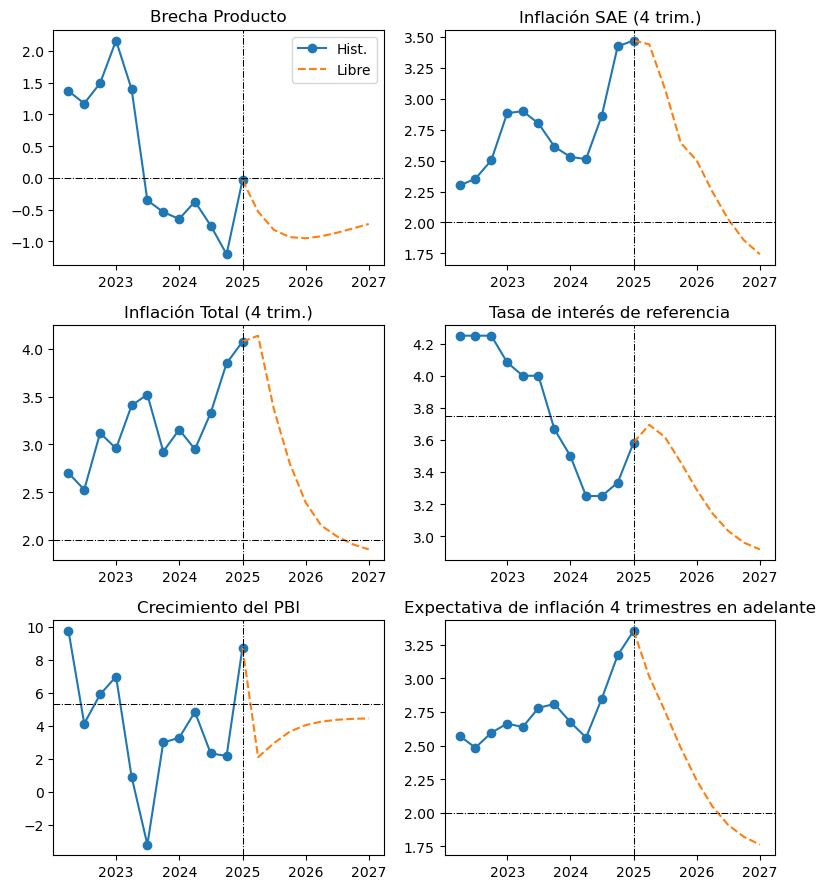

In [14]:
DBdict = {'Libre': FDB}
lista = ['y','D4psae','D4p','i', 'DY', 'ED4p']
listanames = ['Brecha Producto','Inflación SAE (4 trim.)','Inflación Total (4 trim.)',
              'Tasa de interés de referencia', 'Crecimiento del PBI', 'Expectativa de inflación 4 trimestres en adelante']
listaSS = [0,2,2,3.75,5.3,2]
HH = 12
Number_Rows = 3
Number_Cols = 2
fig, axs = HTS.plotTSforecast(DBdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

In [15]:
FDB_report_endog = FDB.loc[FDB.index[-(FH+4):]][var] \
                      .round(2) 

FDB_report_exog = FDB.loc[FDB.index[-(FH+4):]][varexo] \
                      .round(2) 

FDB_report_endog.index = FDB_report_endog.index.to_period('Q').strftime('%Y-Q%q')
FDB_report_exog.index = FDB_report_exog.index.to_period('Q').strftime('%Y-Q%q')

FDB_report_endog_pdf = FDB_report_endog.T
FDB_report_exog_pdf = FDB_report_exog.T

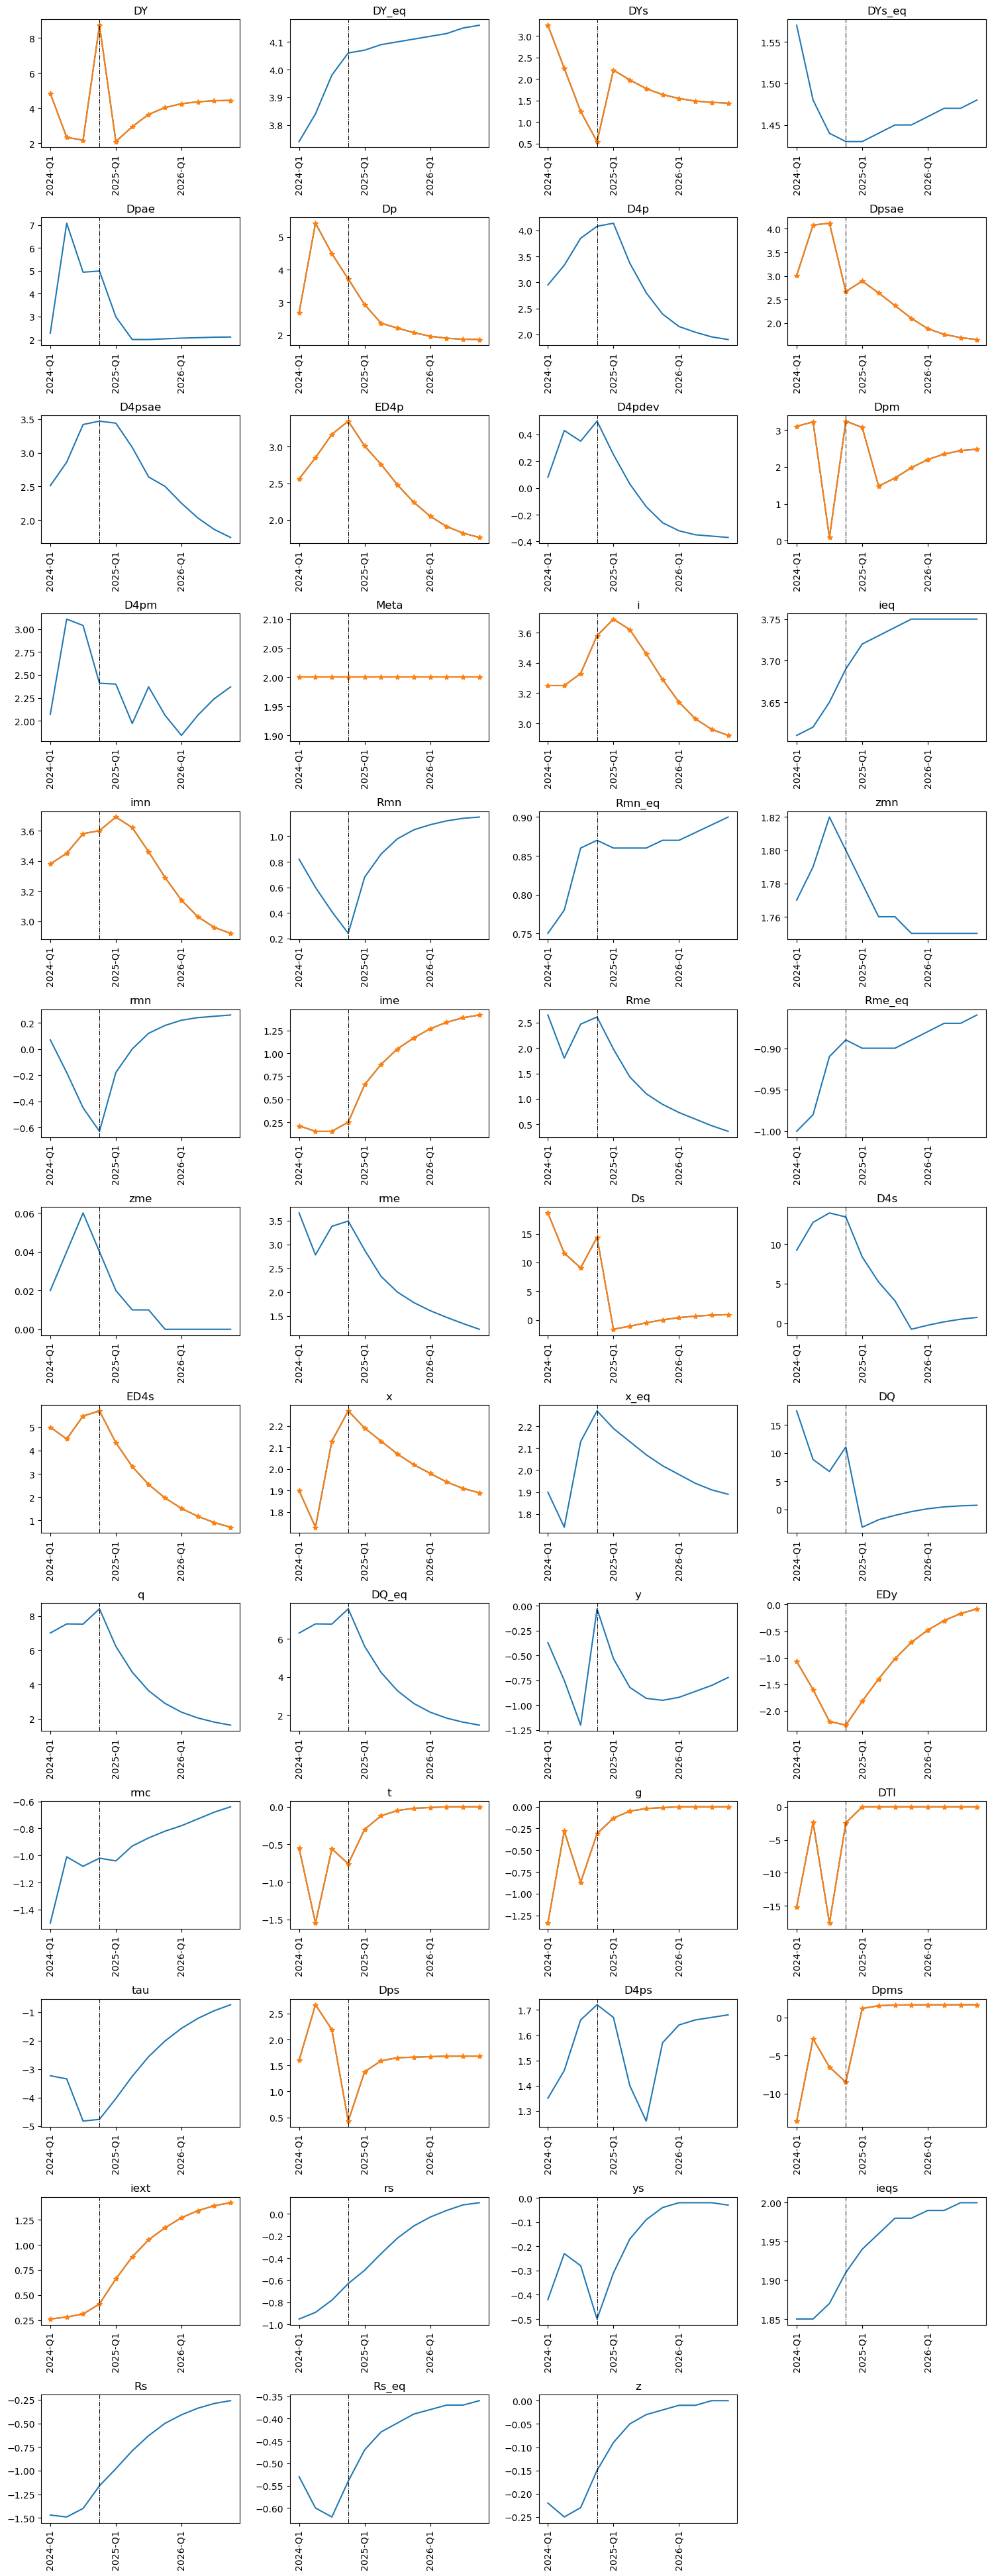

In [16]:
columns = FDB_report_endog.columns
num_cols = len(columns)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))


for idx, col in enumerate(columns):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(FDB_report_endog.index, FDB_report_endog[col], linestyle='-')
    axs[row, col_idx].set_title(col)
    observable = False
    for obs in obsnames:
        if col == obs:
            observable = True
    if observable:
        axs[row, col_idx].plot(FDB_report_endog.index, FDB_report_endog[col], linestyle='-',marker='*')
    axs[row, col_idx].tick_params(axis='x', rotation = 90)
    xticks = axs[row, col_idx].get_xticks()
    axs[row, col_idx].set_xticks(xticks[::4])

    if len(xticks) > 3:
        axs[row, col_idx].axvline(x=xticks[3], color='black', linestyle='-.', linewidth=0.75)


    #axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    #axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

2. Not anticipated conditional forecast

Base

In [17]:
UCond_base = HTS.ReadForeCond(root_path+'Tarea/DataTarea_Exogenas_base.xlsx','2025Q1', FH)

In [18]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_base['UShock'])
print('Unanticipated Hardtunning')
print(UCond_base['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_base['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
            res_Dps  res_ys
2025-03-31      NaN     NaN
2025-06-30      NaN     NaN
2025-09-30      NaN     NaN
2025-12-31      NaN     NaN
2026-03-31      NaN     NaN
2026-06-30      NaN     NaN
2026-09-30      NaN     NaN
2026-12-31      NaN     NaN
Unanticipated Hardtunning
                 DYs        ys      Dpae         t         g  DTI  Dps  \
2025-03-31  2.207918 -0.105134  2.987568 -0.298048 -0.126319  5.0  1.8   
2025-06-30  1.975786 -0.071549  1.998147 -0.116924 -0.050679  5.0  1.8   
2025-09-30  1.781167 -0.048265  2.000000 -0.045869 -0.020332  4.0  1.9   
2025-12-31  1.640418 -0.031798  2.000000 -0.017995 -0.008157  4.0  1.9   
2026-03-31  1.546577 -0.020405  2.000000 -0.007059 -0.003273  3.0  2.0   
2026-06-30  1.488975 -0.015011  2.000000 -0.002769 -0.001313  3.0  2.0   
2026-09-30  1.457705 -0.015015  2.000000 -0.001086 -0.000527  2.0  2.0   
2026-12-31  1.444628 -0.015854  2.000000 -0.000426 -0.000211  2.0  2.0   

  

In [19]:
UFDB_base = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_base)

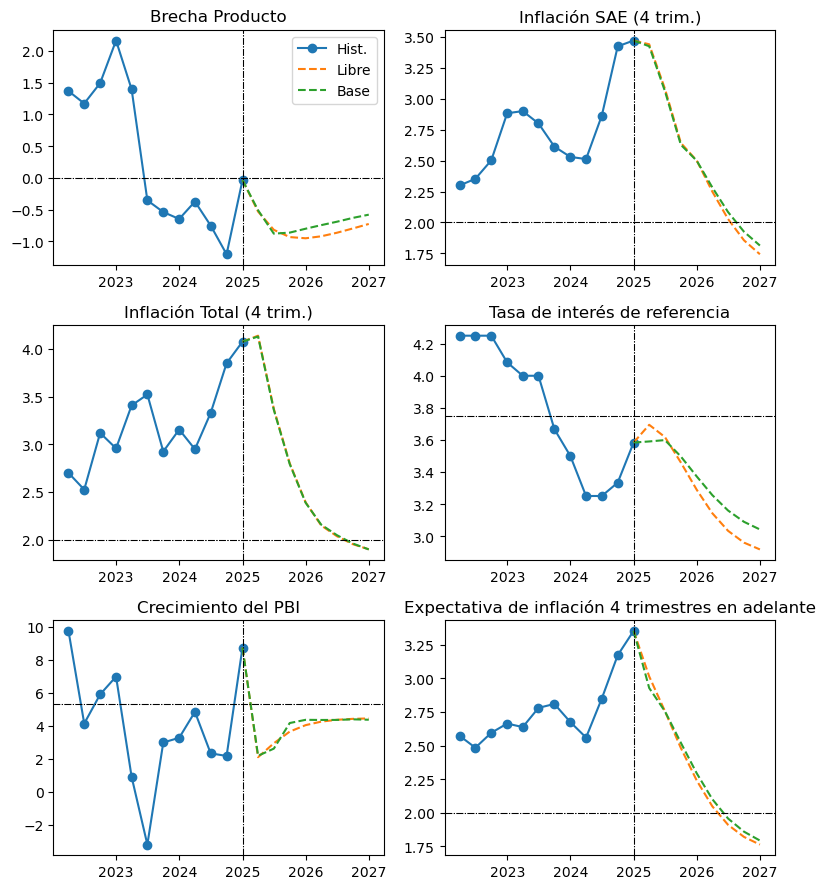

In [20]:
BDdict = {'Libre': FDB,'Base': UFDB_base}
lista = ['y','D4psae','D4p','i', 'DY', 'ED4p']
listanames = ['Brecha Producto','Inflación SAE (4 trim.)','Inflación Total (4 trim.)',
              'Tasa de interés de referencia', 'Crecimiento del PBI', 'Expectativa de inflación 4 trimestres en adelante']
listaSS = [0,2,2,3.75,5.3,2]
HH = 12
Number_Rows = 3
Number_Cols = 2
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

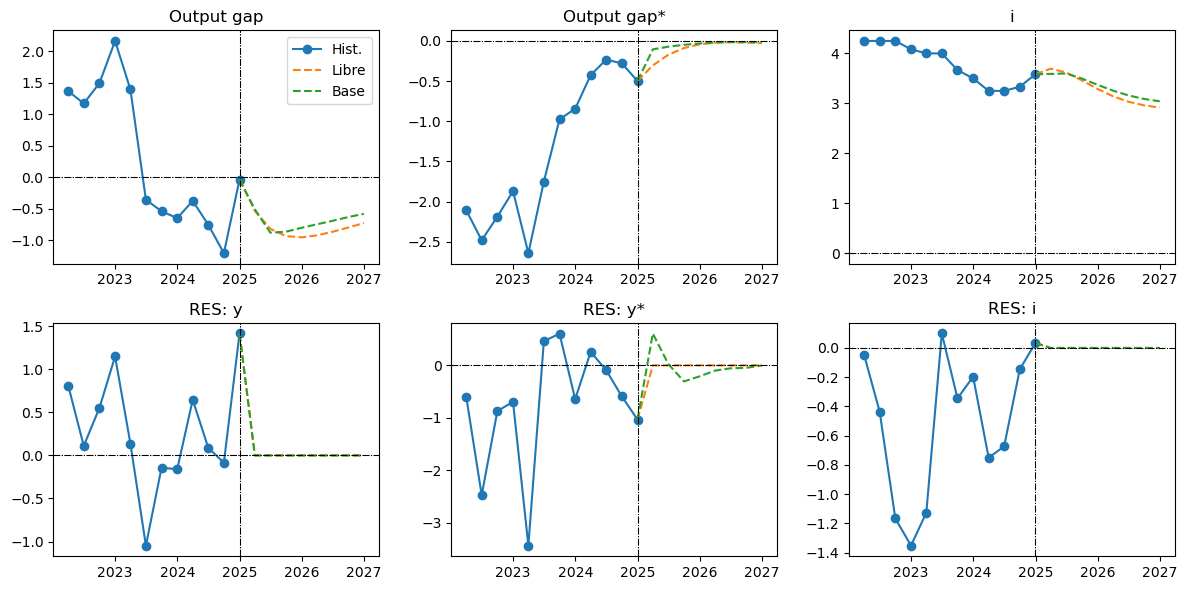

In [21]:
lista = ['y','ys', 'i','res_y','res_ys', 'res_i']
listanames = ['Output gap','Output gap*', 'i','RES: y','RES: y*', 'RES: i']
listaSS = [0,0,0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 3
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

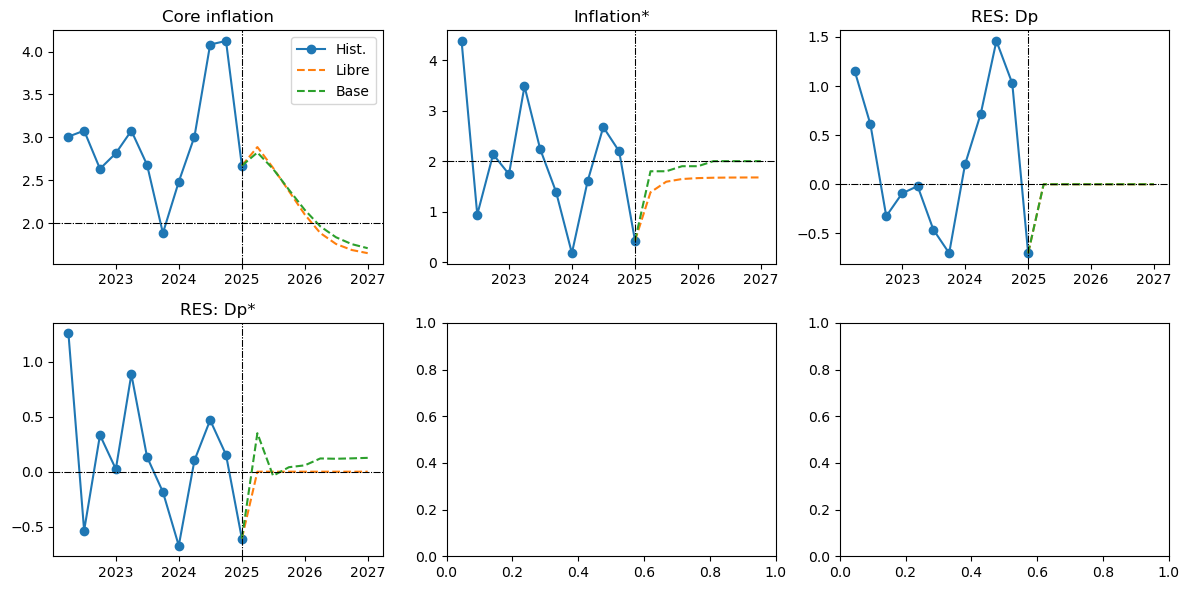

In [22]:
lista = ['Dpsae','Dps','res_Dpsae','res_Dps']
listanames = ['Core inflation','Inflation*','RES: Dp','RES: Dp*']
listaSS = [2,2,0,0]
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

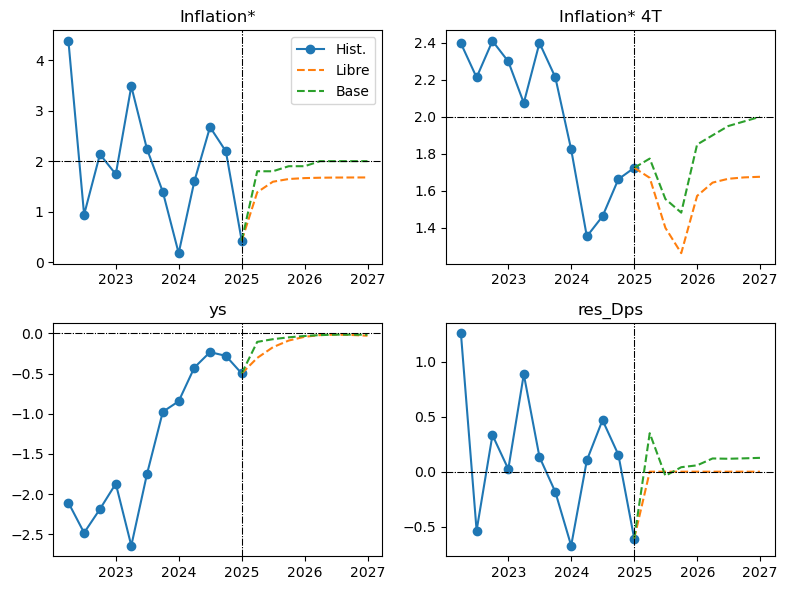

In [23]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['Dps','D4ps','ys', 'res_Dps']
listaSS = [2,2,0,0]
listanames = ['Inflation*','Inflation* 4T','ys','res_Dps']

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,2,2)

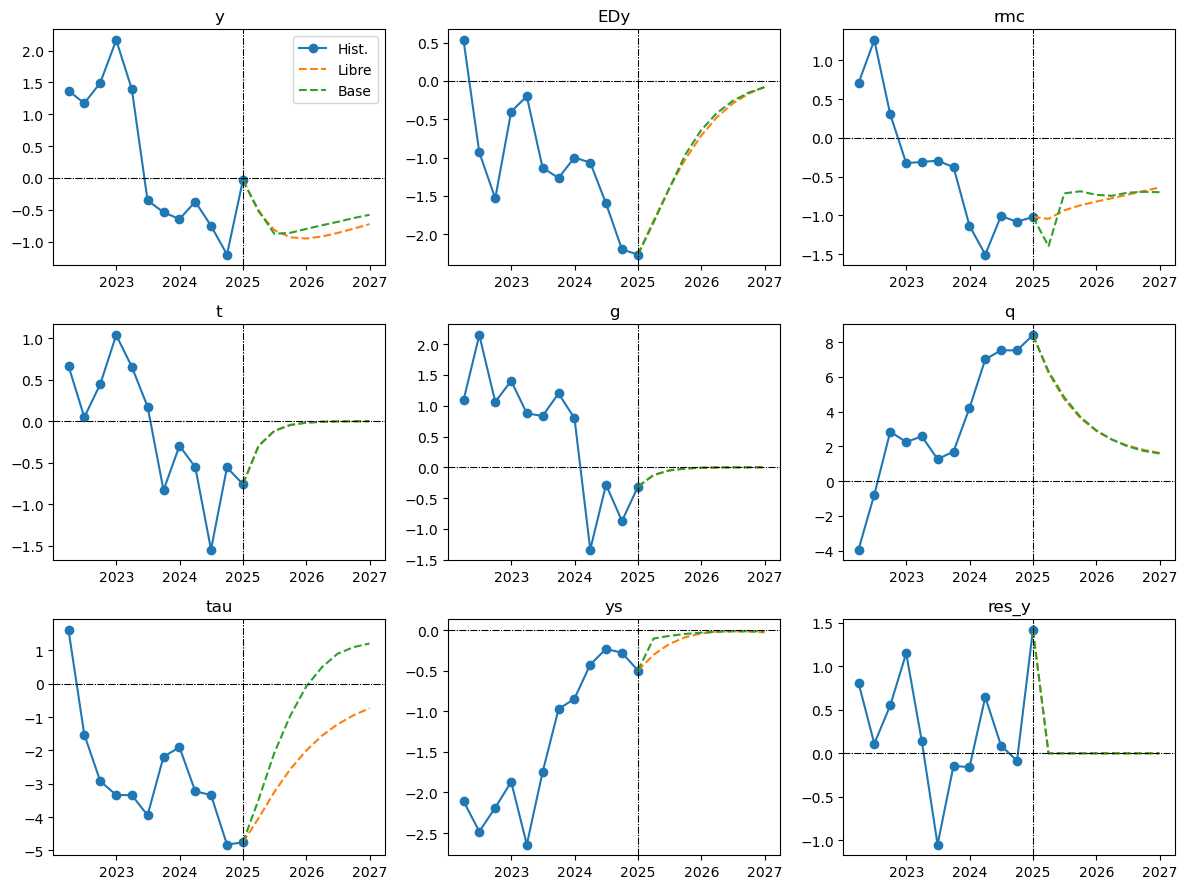

In [24]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,3,3)

In [25]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_base['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_base['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_base['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_base['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_base['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_base['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_base['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_base['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_base['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_base['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB_base.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  \
Brecha: y                  -0.372058   -0.749937   -1.201698   -0.034537   
Inercia: (ay+aEy)*y(-1)    -0.430945   -0.248237   -0.500358   -0.801773   
Confianza: aEy*EDy         -0.136213   -0.204320   -0.280940   -0.289453   
Cond. Mon.: armc*rmc(-1)   -0.339501   -0.451219   -0.301934   -0.324542   
Imp. Rec.: -at*t            0.002764    0.007736    0.002787    0.003799   
Imp. gasto: ag*g           -0.153978   -0.032631   -0.100608   -0.036271   
TCRM: aq*q                  0.162716    0.174880    0.174753    0.195245   
Imp. TI: atau*tau          -0.066133   -0.068470   -0.098857   -0.097495   
Socios: ays*ys             -0.023415   -0.012813   -0.015377   -0.027463   
Res.: m_res_y*res_y         0.612646    0.085137   -0.081166    1.343416   

                          2025-03-31  2025-06-30  2025-09-30  2025-12-31  \
Brecha: y                  -0.508073   -0.876774   -0.860930   -0.799386   
Inercia: (ay+aEy)*y(-1)    -0.023043   -0.338987   -0.584984   -0.574412   
Confianza: aEy*EDy         -0.236136   -0.179241   -0.123038   -0.082089   
Cond. Mon.: armc*rmc(-1)   -0.305547   -0.418751   -0.214443   -0.206460   
Imp. Rec.: -at*t            0.001490    0.000585    0.000229    0.000090   
Imp. gasto: ag*g           -0.014552   -0.005838   -0.002342   -0.000940   
TCRM: aq*q                  0.146817    0.111967    0.086006    0.067917   
Imp. TI: atau*tau          -0.071309   -0.042567   -0.019698   -0.001740   
Socios: ays*ys             -0.005793   -0.003942   -0.002659   -0.001752   
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000   

                          2026-03-31  2026-06-30  2026-09-30  2026-12-31  
Brecha: y                  -0.743107   -0.689126   -0.629096   -0.578192  
Inercia: (ay+aEy)*y(-1)    -0.533350   -0.495801   -0.459785   -0.419733  
Confianza: aEy*EDy         -0.053683   -0.033533   -0.019553   -0.010642  
Cond. Mon.: armc*rmc(-1)   -0.220301   -0.223787   -0.211822   -0.208610  
Imp. Rec.: -at*t            0.000035    0.000014    0.000005    0.000002  
Imp. gasto: ag*g           -0.000377   -0.000151   -0.000061   -0.000024  
TCRM: aq*q                  0.055686    0.046556    0.040537    0.037005  
Imp. TI: atau*tau           0.010007    0.018403    0.022409    0.024684  
Socios: ays*ys             -0.001124   -0.000827   -0.000827   -0.000874  
Res.: m_res_y*res_y         0.000000    0.000000    0.000000    0.000000

# Escenario de riesgo

In [26]:
UCond_riesgo = HTS.ReadForeCond('Riesgo/DataTarea_Exogenas_Riesgo1.xlsx','2025Q1', FH)

tpmfija = True
 
if tpmfija:
    UCond_riesgo['Uvar']['var']['i'] = UFDB_base.i
    UCond_riesgo['Uvar']['shock'].append('res_i')

soft_tunning = True

if soft_tunning:
    for var_soft_tune in UFDB_base:
        if var_soft_tune.startswith('res_'):
            UCond_riesgo['UShock'][var_soft_tune] = UFDB_base[var_soft_tune]

In [27]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond_riesgo['UShock'])
print('Unanticipated Hardtunning')
print(UCond_riesgo['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond_riesgo['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
             res_Dps    res_ys  res_DY_eq  res_Dpae  res_Dpsae  res_ED4p  \
2025-03-31  0.350450  0.607961        0.0  0.034531        0.0       0.0   
2025-06-30 -0.037308  0.024281        0.0 -0.028215        0.0       0.0   
2025-09-30  0.040928 -0.307351        0.0 -0.013382        0.0       0.0   
2025-12-31  0.057796 -0.209209        0.0 -0.006415        0.0       0.0   
2026-03-31  0.120487 -0.101425        0.0 -0.010039        0.0       0.0   
2026-06-30  0.117700 -0.056797        0.0 -0.012791        0.0       0.0   
2026-09-30  0.121479 -0.048018        0.0 -0.012693        0.0       0.0   
2026-12-31  0.125927 -0.003587        0.0 -0.020483        0.0       0.0   

            res_Dpm  res_Meta  res_i  res_ieq  ...  res_EDy         res_t  \
2025-03-31      0.0       0.0    0.0      0.0  ...      0.0 -6.100127e-17   
2025-06-30      0.0       0.0    0.0      0.0  ...      0.0  4.575095e-17   
2025-09-30      0.0       0.0  

In [28]:
UFDB_riesgo = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond_riesgo)

In [29]:
UFDB_report_endog = UFDB_riesgo.loc[UFDB_riesgo.index[-(FH+4):]][var] \
                      .round(2) 

UFDB_report_exog = UFDB_riesgo.loc[UFDB_riesgo.index[-(FH+4):]][varexo] \
                      .round(2)


UFDB_report_endog.index = UFDB_report_endog.index.to_period('Q').strftime('%Y-Q%q')
UFDB_report_exog.index = UFDB_report_exog.index.to_period('Q').strftime('%Y-Q%q')

UFDB_report_endog_pdf = UFDB_report_endog.T
UFDB_report_exog_pdf = UFDB_report_exog.T

In [30]:
print(f'Impacto 2025: {round((UFDB_base.D4p[-5:-4][0] - UFDB_riesgo.D4p[-5:-4][0])*0.10, 2)}')
print(f'Impacto 2026: {round((UFDB_base.D4p[-1:][0] - UFDB_riesgo.D4p[-1:][0])*0.10, 2)}')

Impacto 2025: 0.0
Impacto 2026: 0.03


C:\Users\2663\AppData\Local\Temp\ipykernel_17540\3008223202.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2025: {round((UFDB_base.D4p[-5:-4][0] - UFDB_riesgo.D4p[-5:-4][0])*0.10, 2)}')
C:\Users\2663\AppData\Local\Temp\ipykernel_17540\3008223202.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2026: {round((UFDB_base.D4p[-1:][0] - UFDB_riesgo.D4p[-1:][0])*0.10, 2)}')


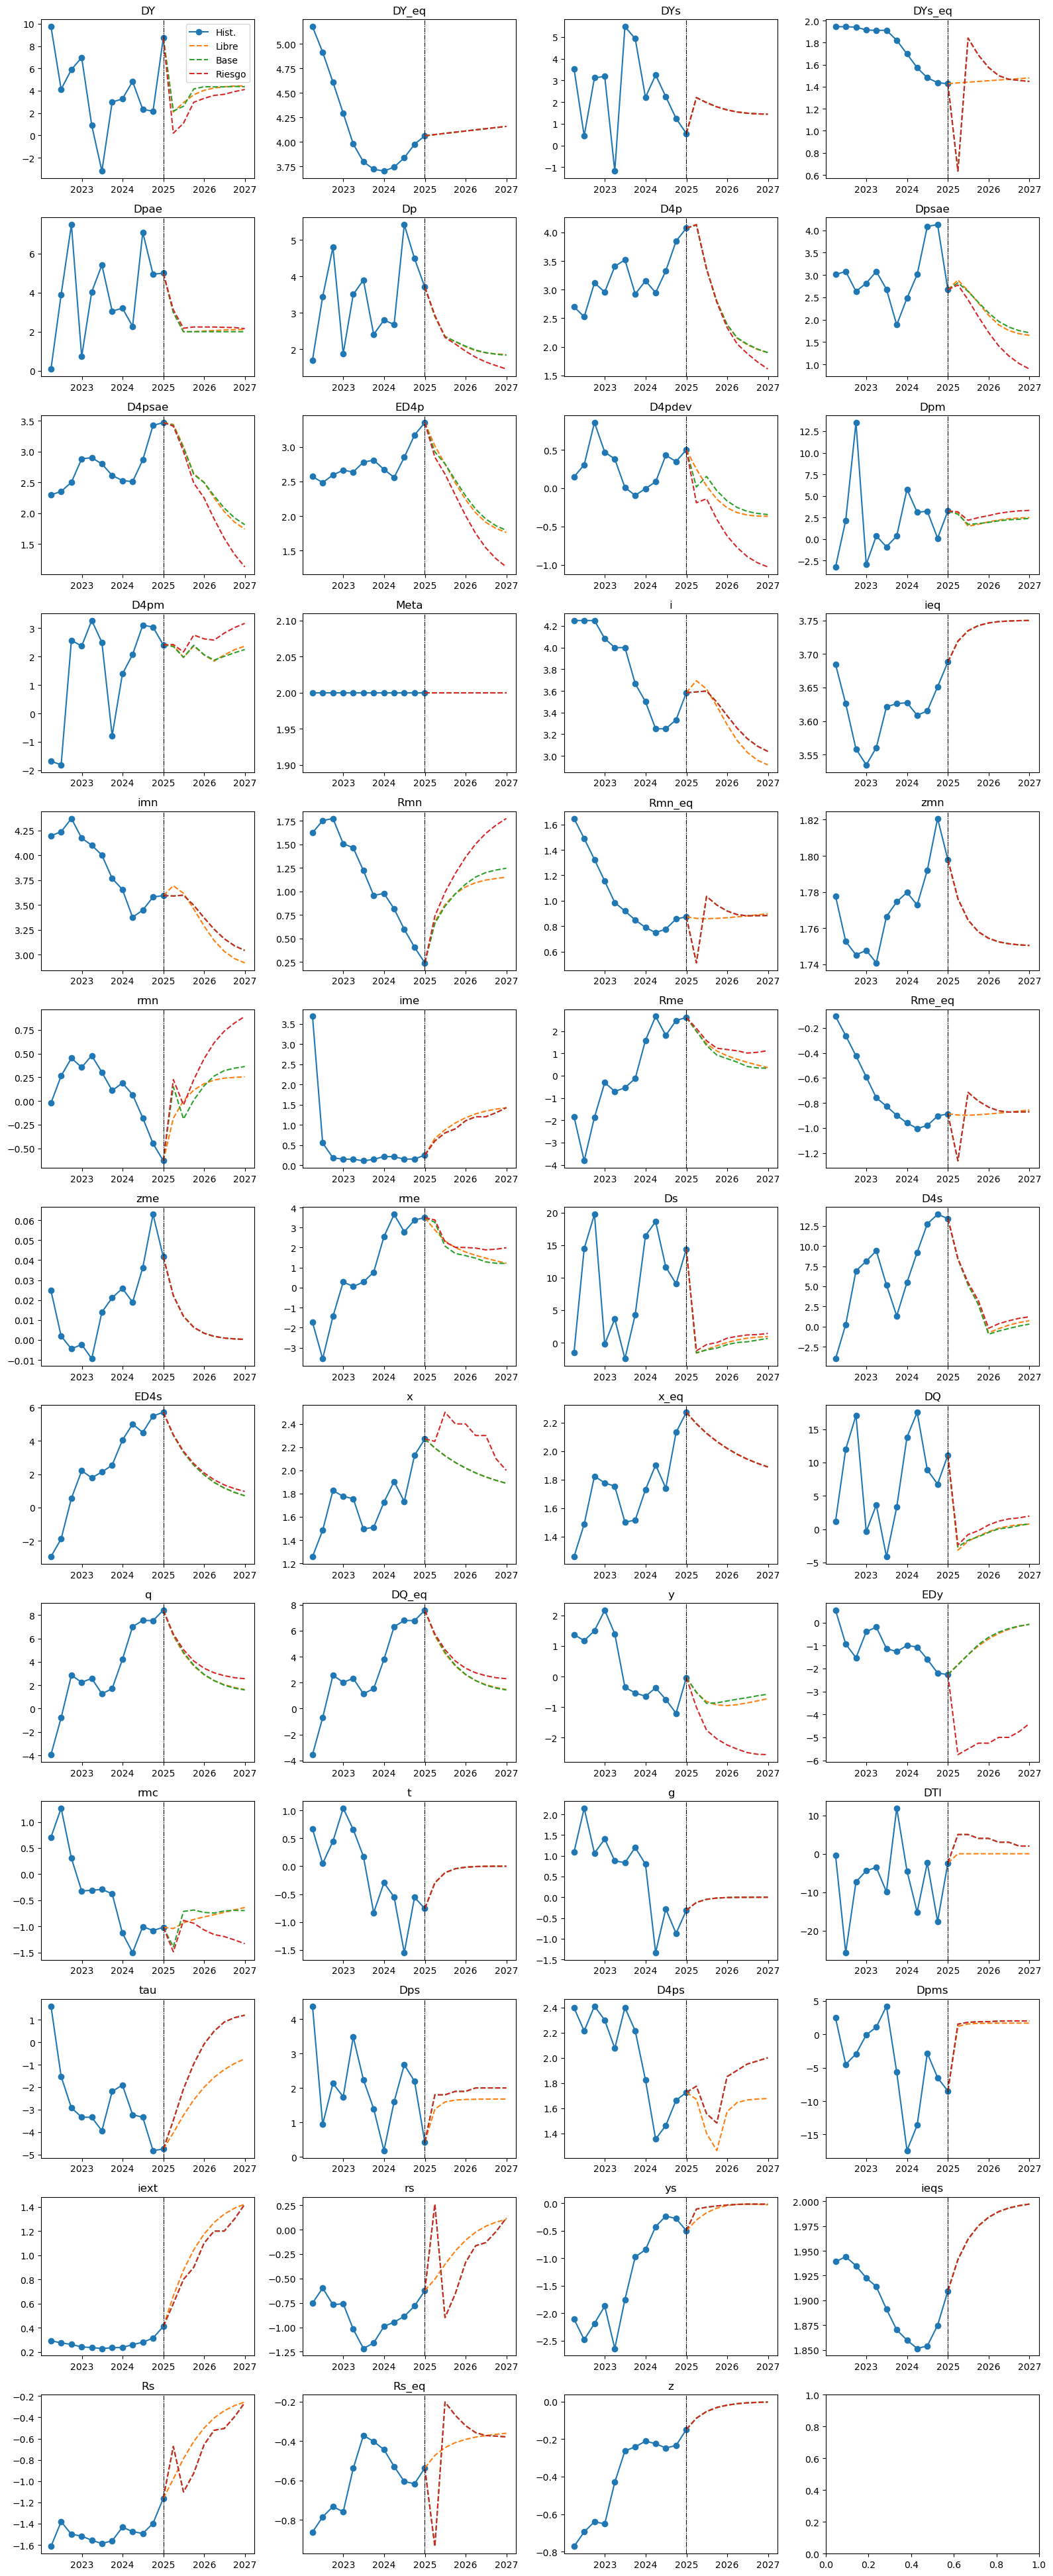

In [31]:
lista = UFDB_report_endog.columns
listaSS = [0 for x in lista]
listanames = lista

BDdict = {'Libre': FDB,'Base': UFDB_base, 'Riesgo': UFDB_riesgo}

num_cols = len(columns)
num_rows = math.ceil(num_cols / 4)

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH, num_rows, 4, SS_plot = False)

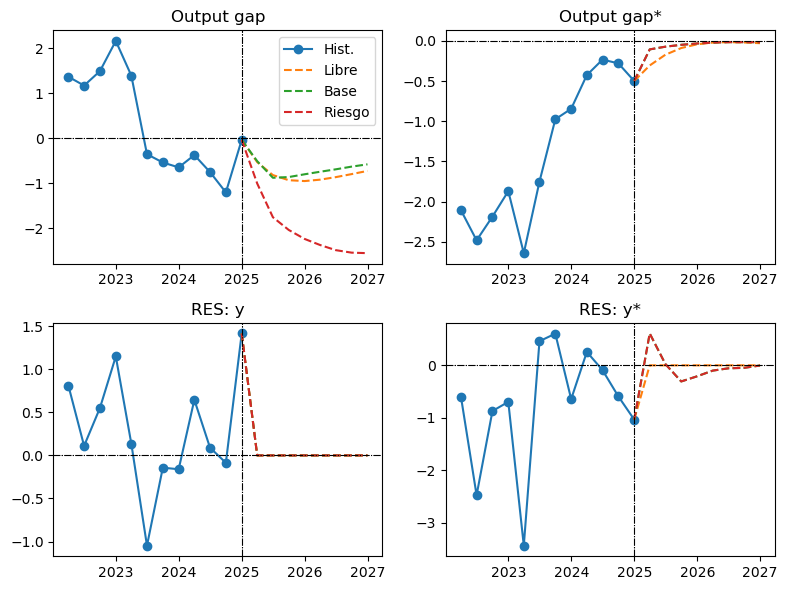

In [32]:
lista = ['y','ys','res_y','res_ys']
listanames = ['Output gap','Output gap*','RES: y','RES: y*']
listaSS = [0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 2
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

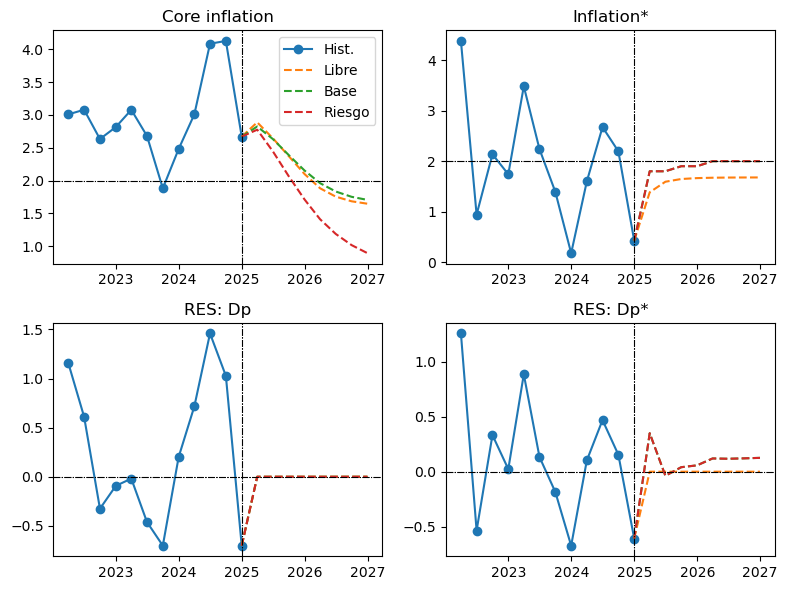

In [34]:
lista = ['Dpsae','Dps','res_Dpsae','res_Dps']
listanames = ['Core inflation','Inflation*','RES: Dp','RES: Dp*']
listaSS = [2,2,0,0]
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

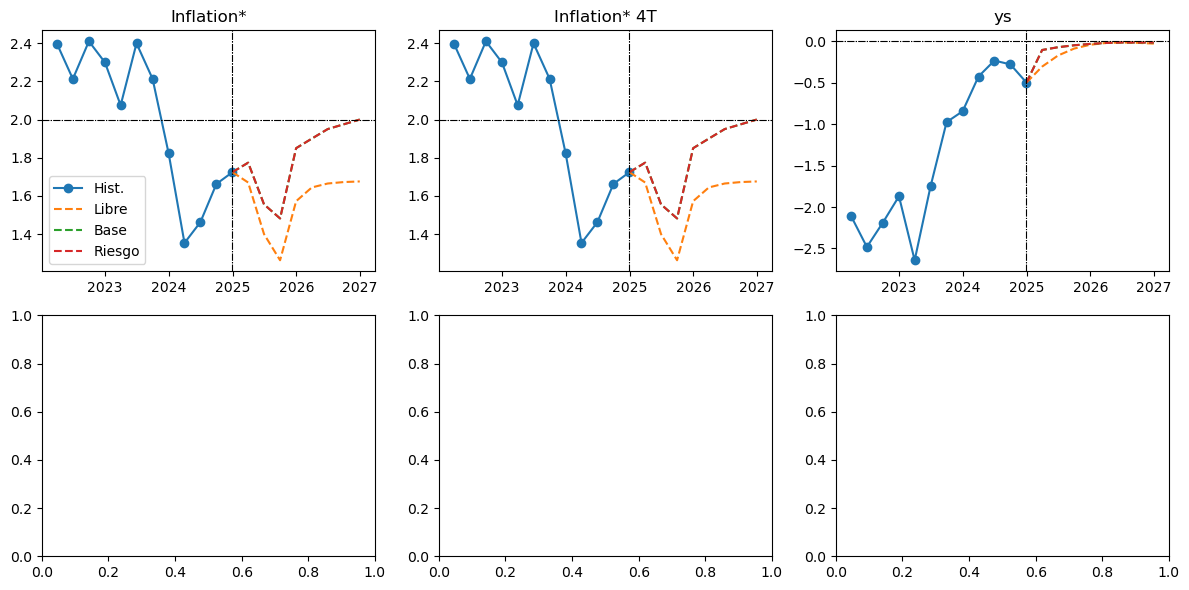

In [ ]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['Dps','D4ps','ys']
listaSS = [2,2,0]
listanames = ['Inflation*','Inflation* 4T','ys']

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,2,3)

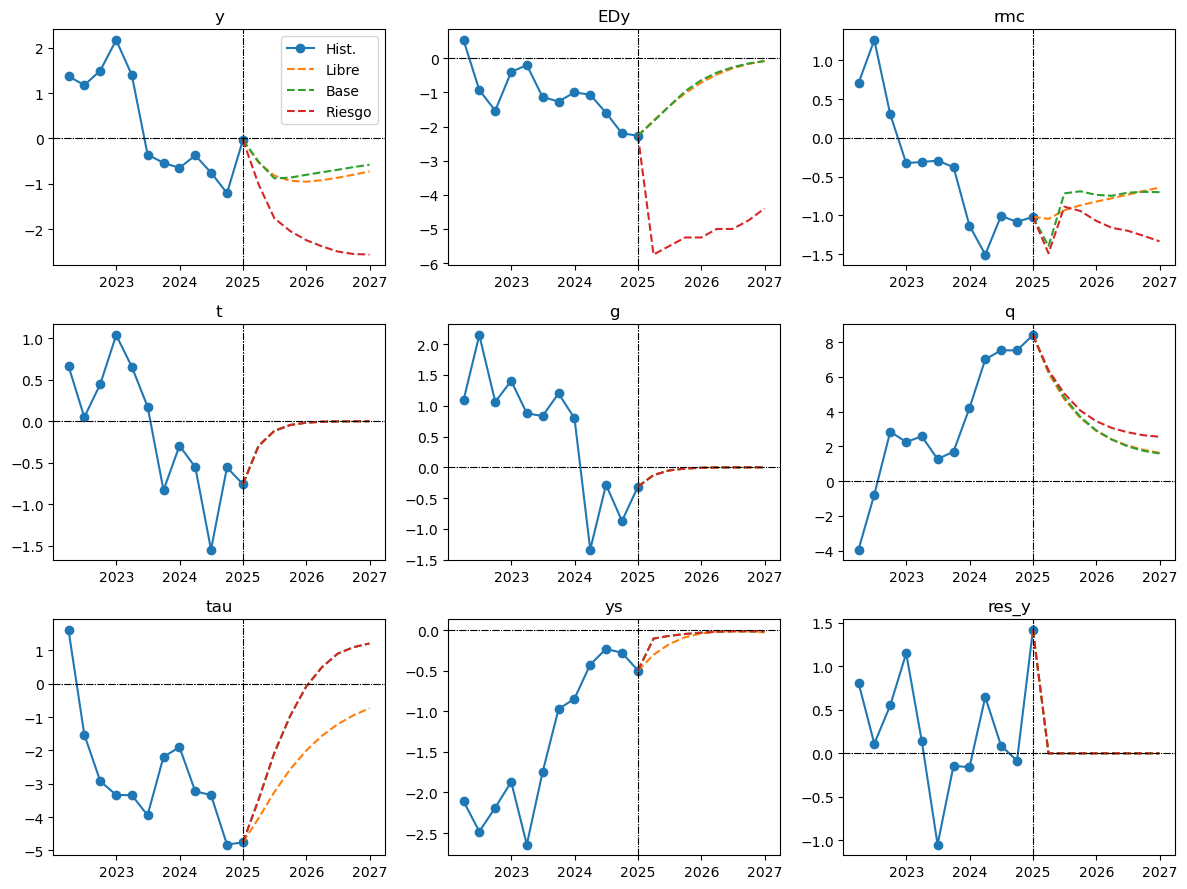

In [36]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,3,3)

* Intento de reporteador

Aquí se ve que la confianza ```EDy``` y las condicniones monetarias ```rmc``` explican principalmente la brecha

In [37]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB_riesgo['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB_riesgo['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB_riesgo['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB_riesgo['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB_riesgo['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB_riesgo['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB_riesgo['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB_riesgo['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB_riesgo['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB_riesgo['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['y','(ay+aEy)*y(-1)','aEy*EDy','armc*rmc(-1)','-at*t','ag*g','aq*q','atau*tau','ays*ys','m_res_y*res_y'], index=UFDB_riesgo.index[-(hist2show+FH):]).T

2024-03-31  2024-06-30  2024-09-30  2024-12-31  2025-03-31  \
y                -0.372058   -0.749937   -1.201698   -0.034537   -1.004919   
(ay+aEy)*y(-1)   -0.430945   -0.248237   -0.500358   -0.801773   -0.023043   
aEy*EDy          -0.136213   -0.204320   -0.280940   -0.289453   -0.734275   
armc*rmc(-1)     -0.339501   -0.451219   -0.301934   -0.324542   -0.305547   
-at*t             0.002764    0.007736    0.002787    0.003799    0.001490   
ag*g             -0.153978   -0.032631   -0.100608   -0.036271   -0.014552   
aq*q              0.162716    0.174880    0.174753    0.195245    0.148109   
atau*tau         -0.066133   -0.068470   -0.098857   -0.097495   -0.071309   
ays*ys           -0.023415   -0.012813   -0.015377   -0.027463   -0.005793   
m_res_y*res_y     0.612646    0.085137   -0.081166    1.343416    0.000000   

                2025-06-30  2025-09-30  2025-12-31  2026-03-31  2026-06-30  \
y                -1.753881   -2.036800   -2.236049   -2.371480   -2.485672   
(ay+aEy)*y(-1)   -0.670482   -1.170190   -1.358953   -1.491892   -1.582251   
aEy*EDy          -0.702350   -0.670425   -0.670425   -0.638500   -0.638500   
armc*rmc(-1)     -0.446355   -0.266209   -0.282475   -0.320729   -0.347693   
-at*t             0.000585    0.000229    0.000090    0.000035    0.000014   
ag*g             -0.005838   -0.002342   -0.000940   -0.000377   -0.000151   
aq*q              0.117069    0.094495    0.080146    0.071100    0.065333   
atau*tau         -0.042567   -0.019698   -0.001740    0.010007    0.018403   
ays*ys           -0.003942   -0.002659   -0.001752   -0.001124   -0.000827   
m_res_y*res_y     0.000000    0.000000    0.000000    0.000000    0.000000   

                2026-09-30  2026-12-31  
y                -2.541141   -2.552702  
(ay+aEy)*y(-1)   -1.658440   -1.695449  
aEy*EDy          -0.606575   -0.561880  
armc*rmc(-1)     -0.359007   -0.378563  
-at*t             0.000005    0.000002  
ag*g             -0.000061   -0.000024  
aq*q              0.061354    0.059403  
atau*tau          0.022409    0.024684  
ays*ys           -0.000827   -0.000874  
m_res_y*res_y     0.000000    0.000000